Training a sandstorm segmentation model
===

>“And are you not [...] a greater analyst than the Googleplex Star Thinker in the Seventh Galaxy of Light and Ingenuity which can calculate the trajectory of every single dust particle throughout a five-week Dangrabad Beta sand blizzard?”
>
>“A five-week sand blizzard?" said Deep Thought haughtily. "[...] Molest me not with this pocket calculator stuff.”

― Douglas Adams, _The Hitchhiker’s Guide to the Galaxy_

---

In this notebook, we train a semantic segmentation model model locally using the sandstorm labels.

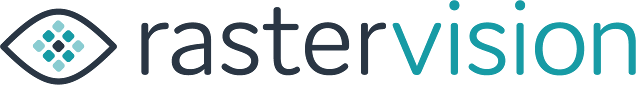

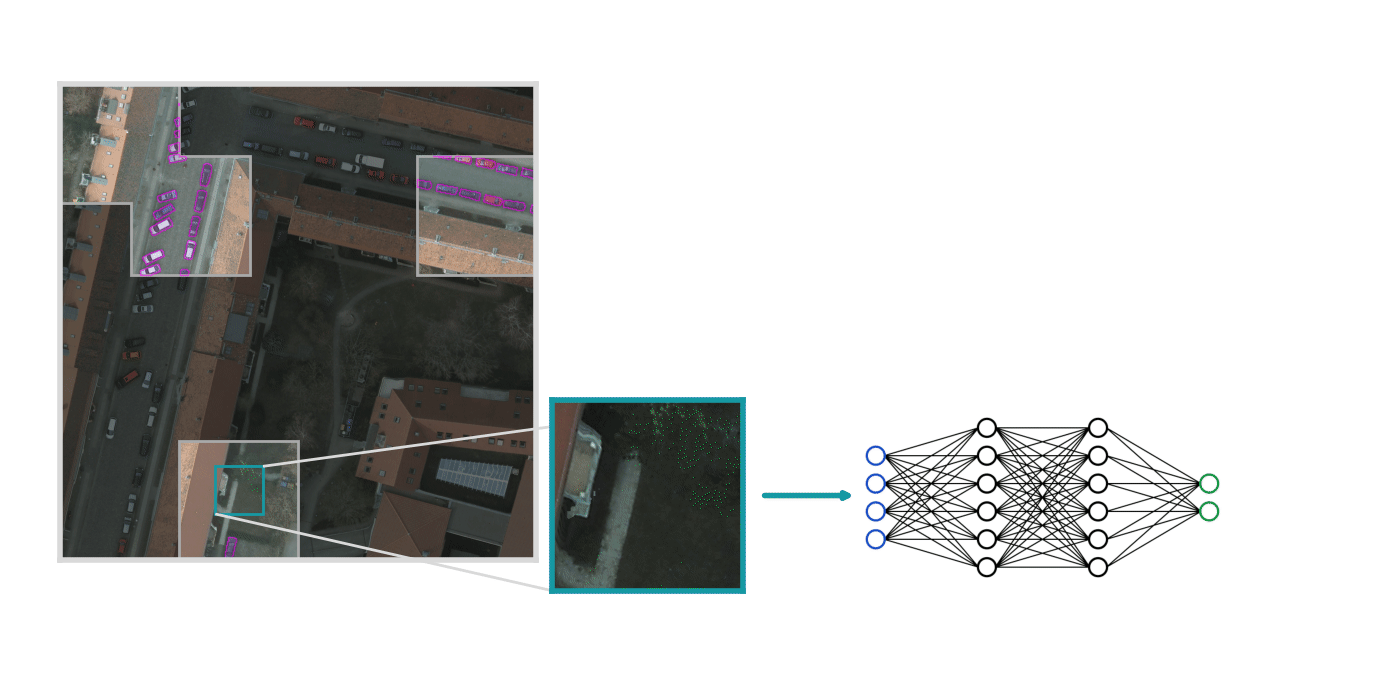

<hr style="border: 2px solid gray">

In [ ]:
from os.path import join
from pathlib import Path

from tqdm.auto import tqdm
import torch

# Setup datasets

In [ ]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['background', 'dust'],
    colors=['lightgray', 'maroon'],
    null_class='background',
)

In [ ]:
img_dir = 'data/training/img/VIIRS_SNPP_CorrectedReflectance_TrueColor/'
label_dir = 'data/training/labels_geojson/'
out_dir = 'data/training_output/2024-05-15/'

In [ ]:
from rastervision.pipeline.file_system.utils import list_paths

img_uris = sorted(list_paths(img_dir, ext='.tif'))
len(img_uris)

In [ ]:
label_uris = [join(label_dir, f'{Path(uri).stem}.json') for uri in img_uris]

In [ ]:
import albumentations as A
from rastervision.core.data import ClassInferenceTransformer
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset)

data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
])


def make_train_ds(img_uri: str, label_uri: str):
    ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
        class_config=class_config,
        image_uri=img_uri,
        label_vector_uri=label_uri,
        label_vector_source_kw=dict(vector_transformers=[
            ClassInferenceTransformer(
                default_class_id=class_config.get_class_id('background'),
                class_config=class_config,
                class_name_mapping=dict(dust_over_land='dust',
                                        dust_over_water='dust'),
            )
        ]),
        size_lims=(512, 513),
        out_size=256,
        max_windows=16,
        padding=0,
        transform=data_augmentation_transform,
    )
    return ds


def make_val_ds(img_uri: str, label_uri: str):
    ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
        class_config=class_config,
        image_uri=img_uri,
        label_vector_uri=label_uri,
        label_vector_source_kw=dict(vector_transformers=[
            ClassInferenceTransformer(
                default_class_id=class_config.get_class_id('background'),
                class_config=class_config,
                class_name_mapping=dict(dust_over_land='dust',
                                        dust_over_water='dust'),
            )
        ]),
        size=512,
        stride=512,
        padding=0,
        out_size=256,
    )
    return ds

In [ ]:
train_size = 300

img_uris_train = img_uris[:train_size]
label_uris_train = label_uris[:train_size]

img_uris_val = img_uris[train_size:]
label_uris_val = label_uris[train_size:]

In [ ]:
from torch.utils.data import ConcatDataset

with tqdm(zip(img_uris_train, label_uris_train), total=train_size) as bar:
    train_dses = [
        make_train_ds(img_uri, label_uri) for img_uri, label_uri in bar
    ]
train_ds = ConcatDataset(train_dses)
len(train_ds)

In [ ]:
val_size = len(img_uris_val)
with tqdm(zip(img_uris_val, label_uris_val), total=val_size) as bar:
    val_dses = [make_val_ds(img_uri, label_uri) for img_uri, label_uri in bar]
val_ds = ConcatDataset(val_dses)
len(val_ds)

In [ ]:
from rastervision.pytorch_learner import SemanticSegmentationVisualizer

viz = SemanticSegmentationVisualizer(class_names=class_config.names,
                                     class_colors=class_config.colors)

In [ ]:
x, y = viz.get_batch(train_ds, 8, shuffle=True)
viz.plot_batch(x, y, show=True)

---

# Setup `Learner`

In [ ]:
model = torch.hub.load('AdeelH/pytorch-fpn:0.3',
                       'make_fpn_resnet',
                       name='resnet18',
                       fpn_type='panoptic',
                       num_classes=len(class_config),
                       fpn_channels=128,
                       in_channels=3,
                       out_size=(256, 256),
                       pretrained=True)

In [ ]:
from rastervision.pytorch_learner import DataConfig

data_cfg = DataConfig(
    class_config=class_config,
    num_workers=4,
)

In [ ]:
from rastervision.pytorch_learner import SolverConfig

solver_cfg = SolverConfig(
    batch_sz=16,
    lr=1e-4,
)

In [ ]:
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig

learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg,
                                                solver=solver_cfg)

In [ ]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir=out_dir,
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
)
learner.log_data_stats()

# Train!

In [ ]:
learner.train(epochs=5)

In [ ]:
learner.save_model_bundle()

---

# Inspect predictions

In [ ]:
preds = learner.predict_dataloader(learner.valid_dl,
                                   return_format='xyz',
                                   batched_output=True,
                                   raw_out=True)

In [ ]:
for _ in range(4):
    x, y, z = next(preds)
    learner.visualizer.plot_batch(x, y, output_path=None, z=z, show=True)

---